# Code to analyze the progressive blackjack side bet. 
## Premise of game: 
### 1. Costs $5 to play. 
### 2. Pays out if the player's hand and dealer's hand combines for a royal flush AND the dealer has blackjack. 
### 3. Royal flush of diamonds pays out the entire meter and other suits pay out 10% of it. 
Author: Evan Tsiklidis

In [114]:
import pandas as pd
import numpy as np
from random import shuffle
from blackjack_sidebet_sim import Blackjack_shoe
import os
import math
import matplotlib.pyplot as plt

In [115]:
cards = ['ace','king','queen','jack','ten','nine','eight','seven','six','five','four','three','two']
suits = ['spades','hearts','clubs','diamonds']

In [116]:
counting_df = pd.read_csv(os.getcwd()+'/counting_systems/high_low_blackjack.csv').drop(['Unnamed: 0'],axis=1)
counting_df.head()

,Card,Value
0,ace_of_spades,-1
1,ace_of_hearts,-1
2,ace_of_clubs,-1
3,ace_of_diamonds,-1
4,king_of_spades,-1


In [117]:
counting_rules = dict(zip(counting_df.Card, counting_df.Value))
small_cards = counting_df[counting_df['Value']>0].Card.tolist()

In [118]:
counting_rules

{'ace_of_spades': -1,
 'ace_of_hearts': -1,
 'ace_of_clubs': -1,
 'ace_of_diamonds': -1,
 'king_of_spades': -1,
 'king_of_hearts': -1,
 'king_of_clubs': -1,
 'king_of_diamonds': -1,
 'queen_of_spades': -1,
 'queen_of_hearts': -1,
 'queen_of_clubs': -1,
 'queen_of_diamonds': -1,
 'jack_of_spades': -1,
 'jack_of_hearts': -1,
 'jack_of_clubs': -1,
 'jack_of_diamonds': -1,
 'ten_of_spades': -1,
 'ten_of_hearts': -1,
 'ten_of_clubs': -1,
 'ten_of_diamonds': -1,
 'nine_of_spades': 0,
 'nine_of_hearts': 0,
 'nine_of_clubs': 0,
 'nine_of_diamonds': 0,
 'eight_of_spades': 0,
 'eight_of_hearts': 0,
 'eight_of_clubs': 0,
 'eight_of_diamonds': 0,
 'seven_of_spades': 0,
 'seven_of_hearts': 0,
 'seven_of_clubs': 0,
 'seven_of_diamonds': 0,
 'six_of_spades': 1,
 'six_of_hearts': 1,
 'six_of_clubs': 1,
 'six_of_diamonds': 1,
 'five_of_spades': 1,
 'five_of_hearts': 1,
 'five_of_clubs': 1,
 'five_of_diamonds': 1,
 'four_of_spades': 1,
 'four_of_hearts': 1,
 'four_of_clubs': 1,
 'four_of_diamonds': 1,
 

In [119]:
run_sims_flag = False
num_sims = 1000000
jackpot = 800000
cost_to_play = 5
win_counter = 0
avg_rt = num_sims*30/3600 #assume 60 seconds/hand in real life. 
lower_rt = num_sims*30/3600 #assume 30 seconds/hand in real life.
upper_rt = num_sims*90/3600 #assume 90 seconds/hand in real life.

In [120]:
if run_sims_flag == True: 
    num_decks_list = [8,7,6,5,4,3,2,1]
    matrix = []
    for num_decks in num_decks_list: 
        data = []
        expectation = -1*num_sims*5
        for running_count in range(4*5*num_decks):  
            shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                            counting_rules=counting_rules,small_cards=small_cards,win_counter=0)        
            for j in range(num_sims): 
                shoe.create_shoe()
                shoe.establish_count()
                shoe.evaluate_jackpot()
            shoe.summarize_results()
            num_wins = shoe.get_expectation_ranges()
            data = [num_decks,running_count,num_wins]
            matrix.append(data)
    df = pd.DataFrame(matrix,columns = ['num_decks','running_count','num_wins'])
    df.to_csv(os.getcwd()+'/counting_systems/simulated_results1.csv')
    df.head()

In [121]:
df = pd.read_csv(os.getcwd()+'/counting_systems/simulated_results1.csv').drop(['Unnamed: 0'],axis=1)
df.head()

,num_decks,running_count,num_wins
0,8,0,9
1,8,1,6
2,8,2,4
3,8,3,4
4,8,4,9


In [122]:
df['Expected_Cash_Return']=(df['num_wins']*jackpot*(0.25+0.025+0.025+0.025)) - num_sims*cost_to_play
df['avg'] =  df['Expected_Cash_Return']/avg_rt
df['upper'] =  df['Expected_Cash_Return']/lower_rt
df['lower'] = df['Expected_Cash_Return']/upper_rt
df.head()

,num_decks,running_count,num_wins,Expected_Cash_Return,avg,upper,lower
0,8,0,9,-2660000.0,-319.2,-319.2,-106.4
1,8,1,6,-3440000.0,-412.8,-412.8,-137.6
2,8,2,4,-3960000.0,-475.2,-475.2,-158.4
3,8,3,4,-3960000.0,-475.2,-475.2,-158.4
4,8,4,9,-2660000.0,-319.2,-319.2,-106.4


In [123]:
df['True_Count'] = df['running_count']/df['num_decks']
df.head()

,num_decks,running_count,num_wins,Expected_Cash_Return,avg,upper,lower,True_Count
0,8,0,9,-2660000.0,-319.2,-319.2,-106.4,0.000
1,8,1,6,-3440000.0,-412.8,-412.8,-137.6,0.125
2,8,2,4,-3960000.0,-475.2,-475.2,-158.4,0.250
3,8,3,4,-3960000.0,-475.2,-475.2,-158.4,0.375
4,8,4,9,-2660000.0,-319.2,-319.2,-106.4,0.500


<AxesSubplot:xlabel='True_Count'>

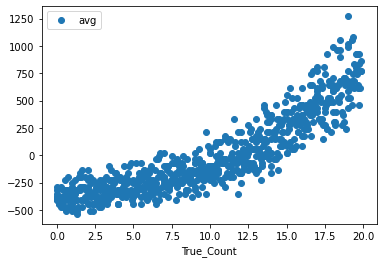

In [124]:
df.plot(x='True_Count', y='avg', style='o')

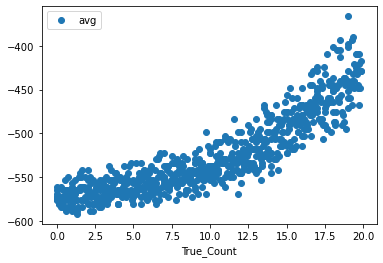

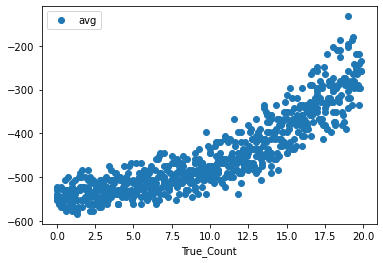

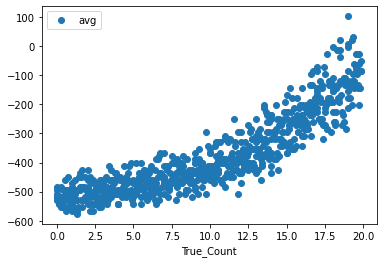

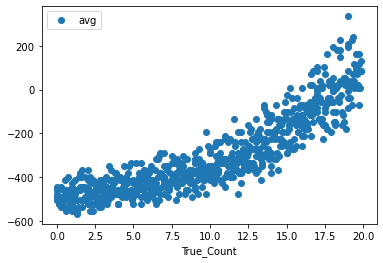

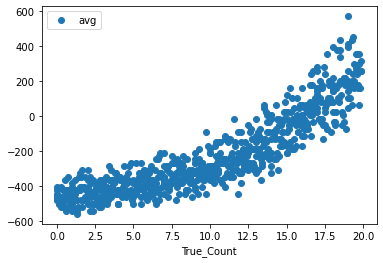

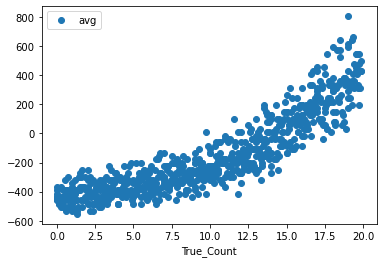

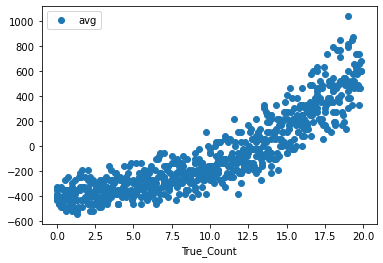

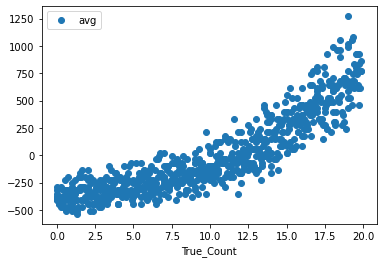

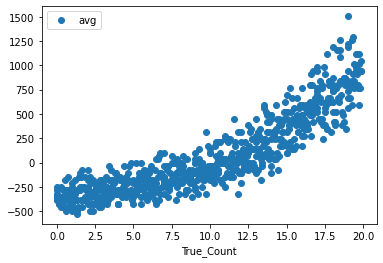

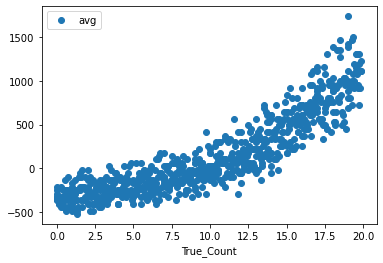

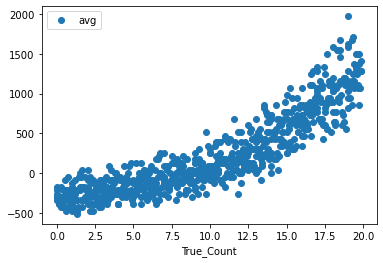

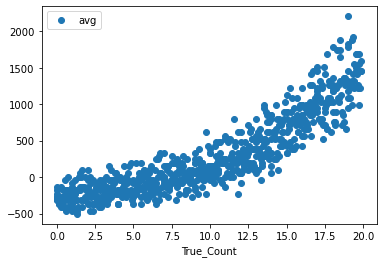

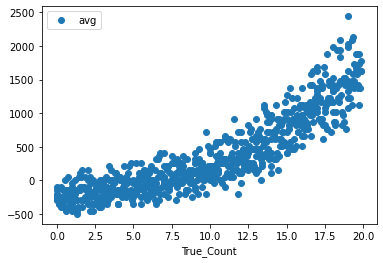

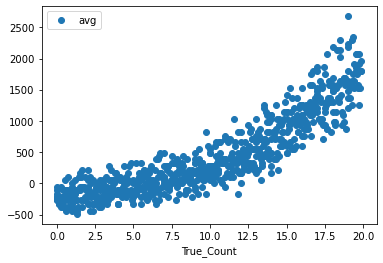

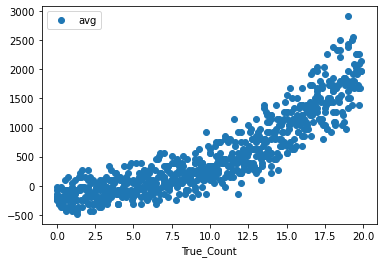

In [125]:
jackpot_list = list(np.arange(100000, 1600000, 100000))
df_final = pd.DataFrame({})
for jackpot in jackpot_list: 
    df['Expected_Cash_Return']=(df['num_wins']*jackpot*(0.25+0.025+0.025+0.025)) - num_sims*cost_to_play
    df['jackpot_value'] = jackpot
    df['avg'] =  df['Expected_Cash_Return']/avg_rt
    df['upper'] =  df['Expected_Cash_Return']/lower_rt
    df['lower'] = df['Expected_Cash_Return']/upper_rt
    df['True_Count'] = df['running_count']/df['num_decks']
    df_final = pd.concat([df_final,df])
    df.plot(x='True_Count', y='avg', style='o')
    

In [126]:
df_final.head()

,num_decks,running_count,num_wins,Expected_Cash_Return,avg,upper,lower,True_Count,jackpot_value
0,8,0,9,-4707500.0,-564.9,-564.9,-188.3,0.000,100000
1,8,1,6,-4805000.0,-576.6,-576.6,-192.2,0.125,100000
2,8,2,4,-4870000.0,-584.4,-584.4,-194.8,0.250,100000
3,8,3,4,-4870000.0,-584.4,-584.4,-194.8,0.375,100000
4,8,4,9,-4707500.0,-564.9,-564.9,-188.3,0.500,100000


In [127]:
df_final.shape

(10800, 9)

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, ensemble

X = df_final[['True_Count','jackpot_value']]
y = df_final[['avg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

params = {
    "n_estimators": 5000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.001,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

/Users/evantsiklidis/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(learning_rate=0.001, max_depth=4, min_samples_split=5,
                          n_estimators=5000)

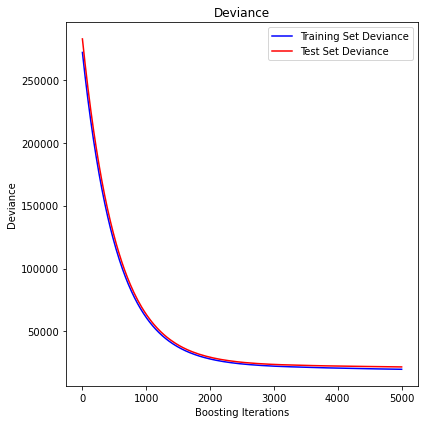

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

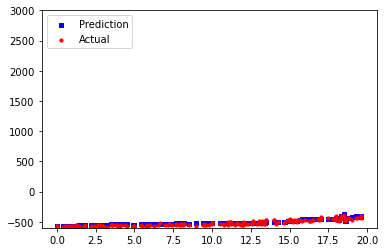

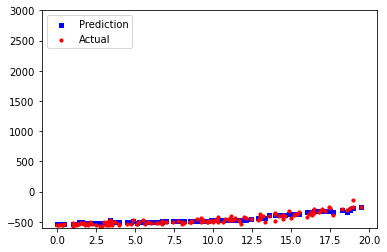

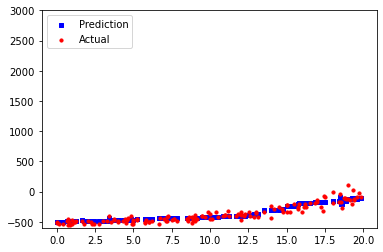

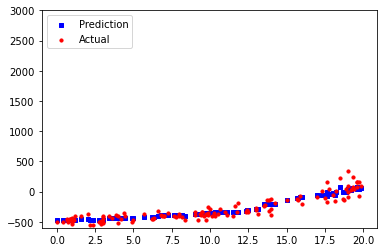

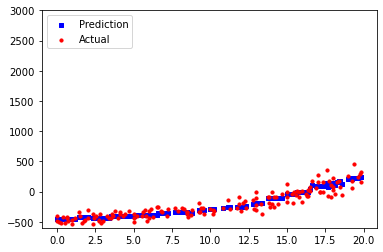

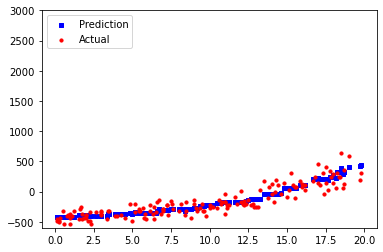

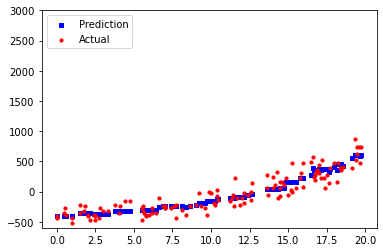

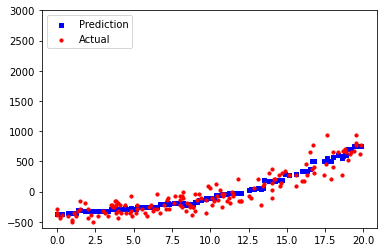

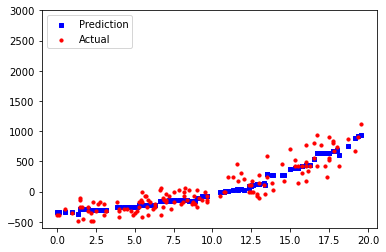

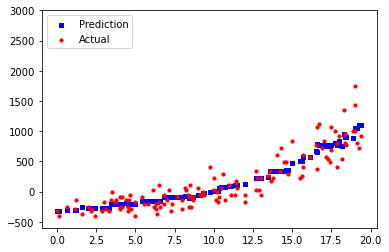

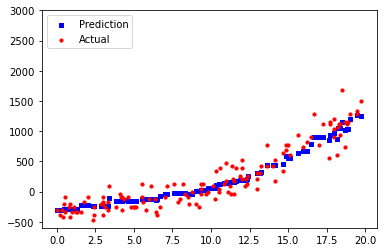

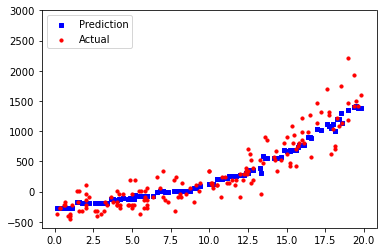

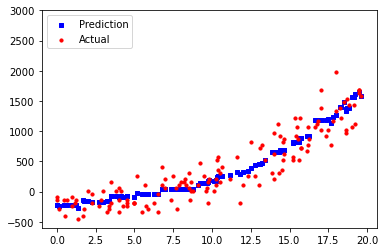

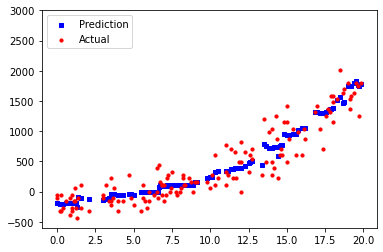

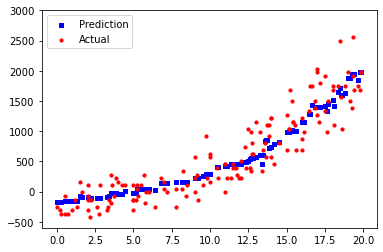

In [139]:
for jackpot in jackpot_list: 
    temp = pd.concat([X_test,y_test],axis=1)
    temp = temp[temp['jackpot_value'] == jackpot]
    X_test_exp = temp[['True_Count','jackpot_value']]
    y_pred = reg.predict(X_test_exp).tolist()
    y_test_exp = temp['avg'].tolist()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(X_test_exp.True_Count, y_pred, s=10, c='b', marker="s", label='Prediction')
    ax1.scatter(X_test_exp.True_Count,y_test_exp, s=10, c='r', marker="o", label='Actual')
    plt.legend(loc='upper left')
    plt.ylim([-600, 3000])
    plt.show()

In [147]:
num_decks=8
running_count = 0
freq_list = []
num_sims = 1000
time_to_finish_all_shoes = 20*num_sims / 60 # (in hours)
for i in range(0,1000):
    shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                counting_rules=counting_rules,small_cards=small_cards,win_counter=0)  
    shoe.create_shoe()
    freq_list = freq_list + shoe.simulate_blackjack_shoe(0.95)

In [148]:
time_to_finish_all_shoes

333.3333333333333

In [156]:
freq_df = pd.DataFrame(freq_list,columns = ['num_decks','running_count'])
freq_df['True_Count'] = freq_df['running_count'] / freq_df['num_decks']
freq_df.head()

,num_decks,running_count,True_Count
0,8,-3,-0.375
1,8,1,0.125
2,8,4,0.500
3,8,5,0.625
4,8,5,0.625


In [160]:
freq_df = pd.DataFrame(freq_df.True_Count.value_counts()).reset_index()
freq_df.columns = ['True_Count','frequency']
freq_df.head()

,True_Count,frequency
0,0.0,2362
1,-1.0,1757
2,1.0,1748
3,-2.0,1164
4,2.0,1124


In [165]:
freq_df['Fraction_of_duration'] = freq_df['frequency'] /freq_df['frequency'].sum()
freq_df.head()

,True_Count,frequency,Fraction_of_duration
0,0.0,2362,0.059050
1,-1.0,1757,0.043925
2,1.0,1748,0.043700
3,-2.0,1164,0.029100
4,2.0,1124,0.028100


In [167]:
freq_df['Hours_with_this_tc'] = freq_df['Fraction_of_duration'] * time_to_finish_all_shoes
freq_df.head()

,True_Count,frequency,Fraction_of_duration,Hours_with_this_tc
0,0.0,2362,0.059050,19.683333
1,-1.0,1757,0.043925,14.641667
2,1.0,1748,0.043700,14.566667
3,-2.0,1164,0.029100,9.700000
4,2.0,1124,0.028100,9.366667
